In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy import stats
folder = 'data/LHC/u ubar -> e+ e- g g/diagram/'
title = folder.split("/")[-2]
print("title: ", title)
# Read the file
with open(folder+"data.csv", 'r') as f:
    data = [float(line.strip()) for line in f if line.strip()]
data = np.array(data)#[:1000000]
len(data)

title:  diagram


1000000

In [8]:
def remove_n_largest(arr, n):
    if n >= len(arr):
        return np.array([])
    largest_indices = np.argsort(arr)[-n:]
    mask = np.ones(arr.shape, dtype=bool)
    mask[largest_indices] = False
    return arr[mask]
data = remove_n_largest(data, 5)
# data=data[:600000]

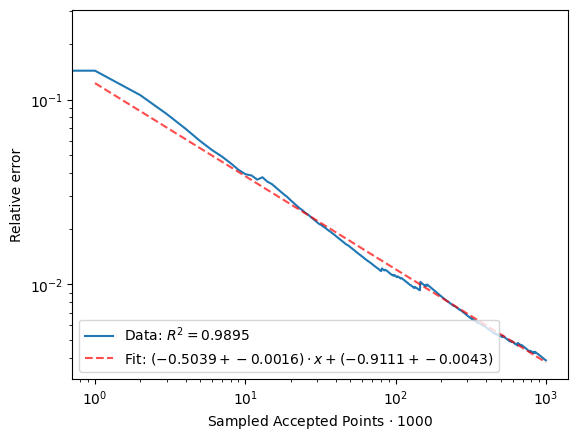

In [9]:
integral = []
rel_err= []
stepsize=1000
x_points = []
for i in range(stepsize, len(data),stepsize):
    integ = data[:i].mean()
    err =  np.sqrt(np.var(data[:i]) / len(data[:i]))
    integral.append(integ)
    rel_err.append(err/integ)
    x_points.append(i)

    
x_points = np.array(range(stepsize, len(data), stepsize))/stepsize
log_x = np.log10(x_points)
log_y = np.log10(rel_err)

r_squared = r2_score(log_y, np.polyfit(log_x, log_y, 1)[0] * log_x + np.polyfit(log_x, log_y, 1)[1])

plt.plot(rel_err, label=f"Data: $R^2={r_squared:.4f}$")


def linear_func(x, a, b):
    return a * x + b

popt, pcov = curve_fit(linear_func, log_x, log_y)
slope, intercept = popt
slope_err, intercept_err= np.sqrt(np.diag(pcov))

fitted_y = 10**(slope * log_x + intercept)
plt.plot(x_points, fitted_y, 'r--', alpha=0.7, label=f'Fit: $({slope:.4f}+-{slope_err:.4f})\\cdot x +({intercept:.4f}+-{intercept_err:.4f})$')


plt.yscale("log")
plt.xscale("log")
plt.xlabel(f"Sampled Accepted Points $\\cdot$ {stepsize}")
plt.ylabel(r"Relative error")

# plt.title(title)
# plt.title(f"{title}\nR²: {r_squared:.4f}")

plt.legend(loc="lower left")

plt.savefig("output/integral_convergence.png")




In [10]:
import os
import json

def read_first_dat_json(folder_path):
   for filename in os.listdir(folder_path):
       if filename.endswith('.dat'):
           with open(os.path.join(folder_path, filename), 'r') as f:
               return json.load(f)
   return None
rundata = read_first_dat_json(folder)

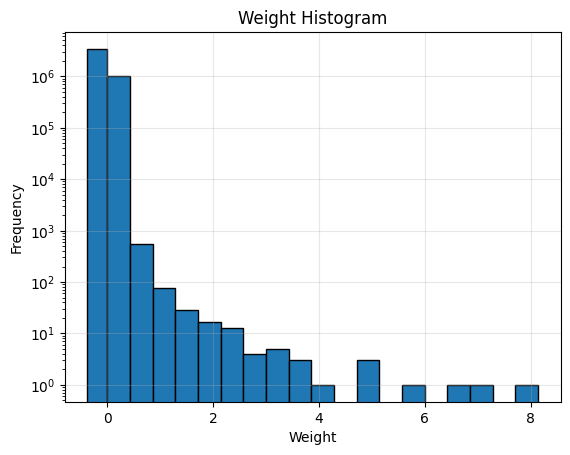

In [11]:
bins = [-(data.max()-0.5)/20, 0]  # First bin for 0 values
bins.extend(np.linspace(0, data.max(), 20))
bins = np.array(bins)
n, _ = np.histogram(data, bins=bins)

n[0] = rundata["ZeroCount"]

bin_centers = (bins[:-1] + bins[1:]) / 2
bin_widths = np.diff(bins)

bars = plt.bar(bin_centers, n, width=bin_widths, edgecolor='black', align='center')

# Color the first bin differently
# bars[0].set_facecolor('red')

plt.title('Weight Histogram')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.savefig("output/weight_histogram.png")
plt.show()

In [12]:
# Your existing data statistics
n_nonzero = len(data)
n_zeros = rundata["ZeroCount"]
n_total = n_nonzero + n_zeros

# Corrected mean
mean_corrected = np.sum(data) / n_total

# Corrected variance and standard deviation
# Var = E[X²] - E[X]²
sum_squares = np.sum(data**2)
mean_squares = sum_squares / n_total  # E[X²] (zeros contribute 0 to sum of squares)
variance_corrected = mean_squares - mean_corrected**2
std_corrected = np.sqrt(variance_corrected)

# Corrected skewness
# Skew = E[(X-μ)³] / σ³
# For zeros: (0-μ)³ = -μ³
# For non-zero data: (x-μ)³
third_moment_nonzero = np.sum((data - mean_corrected)**3)
third_moment_zeros = n_zeros * (-mean_corrected)**3
third_moment_total = (third_moment_nonzero + third_moment_zeros) / n_total
skew_corrected = third_moment_total / (std_corrected**3)

# Corrected kurtosis  
# Kurt = E[(X-μ)⁴] / σ⁴
# For zeros: (0-μ)⁴ = μ⁴
# For non-zero data: (x-μ)⁴
fourth_moment_nonzero = np.sum((data - mean_corrected)**4)
fourth_moment_zeros = n_zeros * (mean_corrected)**4
fourth_moment_total = (fourth_moment_nonzero + fourth_moment_zeros) / n_total
kurtosis_corrected = fourth_moment_total / (std_corrected**4)

# Note: scipy.stats.kurtosis returns excess kurtosis (kurtosis - 3) by default
# If you want to match that behavior:
kurtosis_excess_corrected = kurtosis_corrected - 3

In [13]:
# ue_data = np.mean(data)/max(data)
# ess = (np.sum(data)**2)/np.sum(data**2)
# ess_perc = ess/len(data)*100
# zero_count = np.sum(data==0)/len(data)*100
# skew = stats.skew(data)
# kurtosis = stats.kurtosis(data)

ue_data = mean_corrected/max(data)
ess = (np.sum(data)**2)/np.sum(data**2)
ess_perc = ess/n_total*100
zero_count = n_zeros/n_total*100
accepted_events = (n_total-n_zeros)/n_total*100

sig = 7

results =("Weight mean: " + f"{np.mean(data):.7f}\n"
    "Reference Weight: " + f"{max(data)}\n" 
      "Accepted Events: " + f"{accepted_events:.7f}%\n"
      r"""Unweighting Efficiency: """ + f"{ue_data*100:.2e} %\n"
     "ESS: " + f"{ess_perc:.7f}%\n"
     "variance: " + f"{variance_corrected:.7f}\n"
      "skew: " + f"{skew_corrected:.7f}\n"
     "kurtosis: " + f"{kurtosis_corrected:.7f}\n"
     f"convergence slope: {slope:.7f}+-{slope_err:.7f}\n"
       f"convergence intercept: {intercept:.7f}+-{intercept_err:.7f}")

print(results)
with open("output/data.txt","w") as f:
    f.write(results)
    

# Create LaTeX table
latex_table = r"""
\begin{table}[h]
\centering
\begin{tabular}{|l|r|}
\hline
\textbf{Metric} & \textbf{Value} \\
\hline
Unweighting Efficiency& """ + f"{ue_data*100:.4f}\\%" + r""" \\
\hline
Reference Weight & """ + f"{max(data)}" + r""" \\
\hline
Weight mean & """ + f"{np.mean(data):5f}" + "+-" + f"{np.var(data)**0.5:5f}" + r""" \\
\hline
ESS & """ + f"{ess:.0f}" + r""" \\
\hline
\end{tabular}
\end{table}
"""

#\hline
#ESS Percentage & """ + f"{ess/rundata['PointsAttempted']*100:.4f}\\%" + r""" \\


print(latex_table)

Weight mean: 0.0099139
Reference Weight: 8.14331
Accepted Events: 22.7664571%
Unweighting Efficiency: 2.77e-02 %
ESS: 1.4228745%
variance: 0.0003529
skew: 100.0655688
kurtosis: 26343.8592193
convergence slope: -0.5038944+-0.0016477
convergence intercept: -0.9110849+-0.0042883

\begin{table}[h]
\centering
\begin{tabular}{|l|r|}
\hline
\textbf{Metric} & \textbf{Value} \\
\hline
Unweighting Efficiency& 0.0277\% \\
\hline
Reference Weight & 8.14331 \\
\hline
Weight mean & 0.009914+-0.038397 \\
\hline
ESS & 62498 \\
\hline
\end{tabular}
\end{table}

